
## 1.Introdução

Base por Coleção, segmentaríamos as análise quebrando pela coluna Tipo (Prospecção, Fidelização).

coluna Tipo_lcotação (novo, prospecção) e coluna de quantidade.

A leitura é relativamente simples, nenhum nan foi encontrado.

Entretanto verificamos que a primeira metade de 2020 não está presente, assim como alguns meses de 2025 estão faltantes.

Vamos partis de uma modelagem mensal, parece o mais objetivo e que da oportunidade para o cliente agir sobre a previsão e bem como evita dias ausentes uma vez que claramente os dias não são "contínuos".

Se outra periodicidade for verificada basta alterar nos começo do código.

Em 2020 o primeiro ponto (mensal) não parece correto, o mais provável é que o primeiro dado seja uma "sumarização" de vários meses e não deve ser próprio para modelar.

como temos o problema do começo de ausencia de alguns dados em 2025 e buracos em 2020 o mais objetivo é remover por hora e depois podemos considerar se os dados podem ou nao ser incluídos é até interessante remover 2025, para verificarmos se as hipoteses se confirmam no período de teste

Verificamos que a periodicidade trimestral trás um padrão sazonal interessante (graficamente) só que muito fraco do ponto de vista estatístico, o padrao sazonal mais forte é sem dúvidas o de 12m, mesmo com "baixa" amostragem.

No final vemos um padrao sazonal forte em 12m, a série claramente tem tendencia positiva e os agrupamentos segmento-tipo nao se diferenciam muito, a série pode ser modelada como uma só depois o fit do modelo pode ser feito ou splitado em um pós fit deixando a proporção de casa grupo.

O dado tem alguma assimetria, usar ele como log pode ser interessante.

Próximos passos:

-verificar e mostrar os findings para o pessoal do poliedro

-montar uma estrutura de train test-split de series temporais para fazer sem safras anuais

-montar um aic/bic para testar diferentes padroes no sarimax/outro modelo

-calcular os erros e avaliar a solucao

In [10]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from config import (PARAMS_PATHS
                    )

sns.set_style('whitegrid')
output_plots=os.path.join(os.getcwd(),'plots')

for key, path in PARAMS_PATHS.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f'unable to find a proper file to {key} with the path:\n{path}')

export_file=os.path.join(PARAMS_PATHS.get('output_path'),'compile_exploratory_analysis.xlsx')

input_path=PARAMS_PATHS.get('input_path')
sheet_name='Base por Coleção'
try:
    #esse nome sem utf-8 pode dar merda
    df_raw_input = pd.read_excel(input_path, engine="openpyxl", sheet_name=sheet_name)
except ValueError as e:
        sheets = pd.ExcelFile(input_path, engine="openpyxl").sheet_names
        df_raw_input = pd.read_excel(input_path, engine="openpyxl", sheet_name=sheets[0])



df_raw_input.sort_values(by='Data', inplace=True)
df_raw_input.reset_index(inplace=True, drop=True)
df_raw_input['Mes'] = df_raw_input['Data'].dt.to_period('M').dt.to_timestamp() #coloca a data do dia sempre em 01
#trimestre pode ser uma boa alternativa
df_raw_input['Trimestre'] = df_raw_input['Data'].dt.to_period('Q').dt.to_timestamp()
display(df_raw_input.head(2).T)
display(df_raw_input[df_raw_input['Quantidade_Total']==df_raw_input['Quantidade_Total'].max()].T)
display(df_raw_input[df_raw_input['Quantidade_Total']==df_raw_input['Quantidade_Total'].min()].T)

before = len(df_raw_input)
df_raw_input = df_raw_input.drop_duplicates(keep="first")
after = len(df_raw_input)
removed = before - after
display(f'duplicatas removidas {removed}')

df_raw_input.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,0,1
Nome_Produto,5º Ano - Phases,1ª Série - Lumen
Segmento,EFAI,EM
Ano,2020,2020
Data,2020-05-22 00:00:00,2020-05-22 00:00:00
Tipo,Fidelização,Fidelização
Tipo_lcotacao,Renovação,Renovação
Id_Escola,0016g00000BIRYRAA5,0016g00000BIRXEAA5
Cidade,Itaquaquecetuba,São Manuel
UF,SP,SP
Quantidade_Total,7,18


,1227
Nome_Produto,3ª Série e PV - Medicina
Segmento,PV
Ano,2020
Data,2020-05-22 00:00:00
Tipo,Fidelização
Tipo_lcotacao,Renovação
Id_Escola,0016g00000BIRYdAAP
Cidade,São Paulo
UF,SP
Quantidade_Total,1840


,1248,1262,1263,1390,1393,2128,4494,4531,5293,5929,...,25683,25692,25707,26593,26618,26619,26678,27423,27446,27486
Nome_Produto,9º Ano - Callis,1ª Série - Lumen,2ª Série - Lumen,2 anos - Gressus,5 anos - Gressus,3 anos - Gressus,3º Ano - Phases,4º Ano - Phases,2 anos - Gressus,2 anos - Gressus,...,3ª Série e PV - Hexa,3ª Série e PV - Hexa,3ª Série e PV - Medicina,2 anos - Gressus,3º Ano - Phases,3 anos - Gressus,5º Ano - Phases,5º Ano - Phases,4º Ano - Phases,3ª Série e PV - Hexa
Segmento,EFAF,EM,EM,EI,EI,EI,EFAI,EFAI,EI,EI,...,PV,PV,PV,EI,EFAI,EI,EFAI,EFAI,EFAI,EM
Ano,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,...,2025,2025,2025,2025,2025,2025,2025,2025,2025,2025
Data,2020-05-22 00:00:00,2020-05-22 00:00:00,2020-05-22 00:00:00,2020-05-22 00:00:00,2020-05-22 00:00:00,2020-05-22 00:00:00,2020-08-24 00:00:00,2020-08-24 00:00:00,2020-09-14 00:00:00,2020-09-30 00:00:00,...,2024-09-17 00:00:00,2024-09-17 00:00:00,2024-09-17 00:00:00,2024-10-24 00:00:00,2024-10-24 00:00:00,2024-10-24 00:00:00,2024-10-28 00:00:00,2024-11-29 00:00:00,2024-11-29 00:00:00,2024-12-02 00:00:00
Tipo,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Prospecção,...,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização,Fidelização
Tipo_lcotacao,Renovação,Renovação,Renovação,Renovação,Renovação,Renovação,Ampliação,Renovação,Renovação,Novo,...,Renovação,Renovação,Renovação,Ampliação,Renovação,Renovação,Renovação,Doação,Doação,Doação
Id_Escola,0016g00000BIRXDAA5,0016g00000BIRXVAA5,0016g00000BIRXVAA5,0016g00000BIRZ7AAP,0016g00000BIRZ7AAP,0016g00000BIRZYAA5,0016g00000BIRXAAA5,0016g00000BIRXAAA5,0016g00000BIRXWAA5,0016g00000bFf1hAAC,...,0016g00000BIRWPAA5,0016g00000BIRbLAAX,0016g00000BIRWcAAP,0014v00002YCtf7AAD,0014v00002YCtf7AAD,0014v00002YCtf7AAD,0014v00002ZiYcjAAF,0016g00000BIRWpAAP,0016g00000BIRWpAAP,0016g00000BIRVNAA5
Cidade,Taubaté,Amparo,Amparo,São Paulo,São Paulo,Jacutinga,Guararema,Guararema,São Paulo,Bertioga,...,Marília,São José do Rio Preto,Presidente Prudente,Aracruz,Aracruz,Aracruz,Valinhos,Itapecerica da Serra,Itapecerica da Serra,Lucas do Rio Verde
UF,SP,SP,SP,SP,SP,MG,SP,SP,SP,SP,...,SP,SP,SP,ES,ES,ES,SP,SP,SP,MT
Quantidade_Total,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


'duplicatas removidas 49'

<class 'pandas.core.frame.DataFrame'>
Index: 27882 entries, 0 to 27930
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Nome_Produto      27882 non-null  object        
 1   Segmento          27882 non-null  object        
 2   Ano               27882 non-null  int64         
 3   Data              27882 non-null  datetime64[ns]
 4   Tipo              27882 non-null  object        
 5   Tipo_lcotacao     27882 non-null  object        
 6   Id_Escola         27882 non-null  object        
 7   Cidade            27882 non-null  object        
 8   UF                27882 non-null  object        
 9   Quantidade_Total  27882 non-null  int64         
 10  Mes               27882 non-null  datetime64[ns]
 11  Trimestre         27882 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(7)
memory usage: 2.8+ MB


In [11]:
df_raw_input.shape

(27882, 12)

In [12]:
input_path

'd:\\\\mestrado\\\\projeto_poliedro\\\\data\\\\Desafio 2 - Tiragem - Base de Dados.xlsx'

## 2.Série Sem Agrupamentos (Total)

Partimos de um agrupamento só do ponto de vista da data e depois vamos evoluir para cada um dos grupos designados.
Adicionamos o campo de média móvel deve ser útil para verificar o movimento do dado.
Aqui vemos que o mes inicial nao deve parecer correto, claramente o valor é analogo ao ano todo dos períodos seguintes, mas precisamos confirmar com a poliedro

,Mes,Quantidade_Total,mm12
0,2020-05-01,148458,NaN
1,2020-06-01,6002,77230.000000
2,2020-07-01,3789,52749.666667
3,2020-08-01,27494,46435.750000
4,2020-09-01,42247,45598.000000
...,...,...,...
56,2025-01-01,2226,18997.416667
57,2025-02-01,4262,18923.000000
58,2025-03-01,275,18837.833333
59,2025-04-01,154,17870.166667


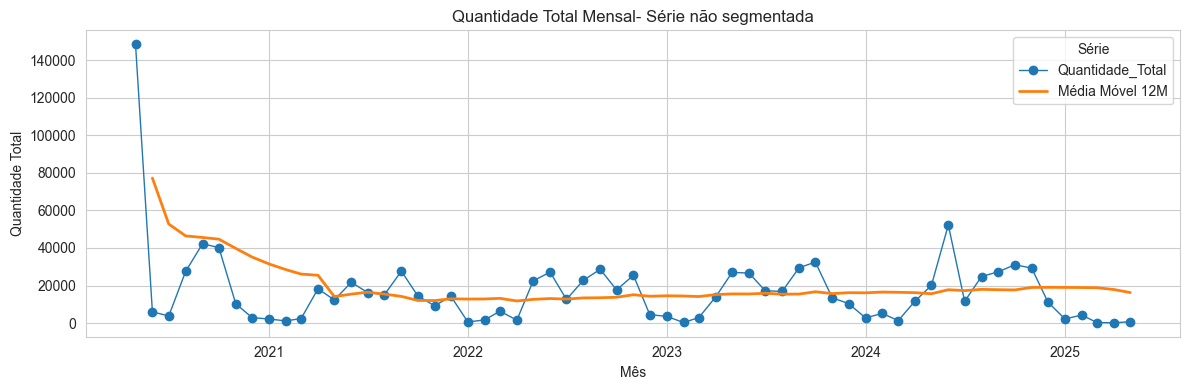

In [18]:
df_total=df_raw_input.groupby('Mes')[['Quantidade_Total']].sum().reset_index()
df_total['mm12'] = df_total['Quantidade_Total'].rolling(12, min_periods=2).mean()
display(df_total)

plt.figure(figsize=(12,4))
plt.plot(df_total['Mes'], df_total['Quantidade_Total'], marker='o', linewidth=1, label='Quantidade_Total')
plt.plot(df_total['Mes'], df_total['mm12'], linewidth=2, label='Média Móvel 12M')
plt.title('Quantidade Total Mensal- Série não segmentada')
plt.xlabel('Mês');plt.ylabel('Quantidade Total')
plt.legend(title='Série')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'media_movel_12M_sem_segmento.png'))
plt.show()

## 3.Agrupamentos e Analise Mensal

mes deve ser o bastantem para reproduzir um padrao sazonal e deve ser o mais proximo de uma regra de negocio

o grupo de data deve ser alinhado previamente

ainda falta definir com a equipe de negocio uma segmentação mais adequada 

nao sabemos de UF (SP-RJ..) deve ser um ponto relevante

futuramente deve ser movido para o config.py

Empiricamente, podemos ver os meses com padrao sazonal


Os meses de 5,6,8,9,10 parecem ter uma maior demanda

,Segmento,Tipo,Mes,Quantidade_Total,ano,mes_num,trimestre,mm3,mm12
0,EFAF,Fidelização,2020-05-01,39634,2020,5,2020-04-01,39634.000000,39634.000000
1,EM,Fidelização,2020-05-01,37827,2020,5,2020-04-01,37827.000000,37827.000000
2,EI,Fidelização,2020-05-01,12042,2020,5,2020-04-01,12042.000000,12042.000000
3,EFAI,Fidelização,2020-05-01,34404,2020,5,2020-04-01,34404.000000,34404.000000
4,PV,Fidelização,2020-05-01,24551,2020,5,2020-04-01,24551.000000,24551.000000
...,...,...,...,...,...,...,...,...,...
497,PV,Fidelização,2025-04-01,50,2025,4,2020-04-01,133.333333,1507.083333
498,EM,Fidelização,2025-04-01,104,2025,4,2020-04-01,240.333333,4466.416667
499,EFAI,Prospecção,2025-05-01,144,2025,5,2020-04-01,189.000000,475.083333
500,EFAF,Prospecção,2025-05-01,139,2025,5,2020-04-01,187.333333,531.750000


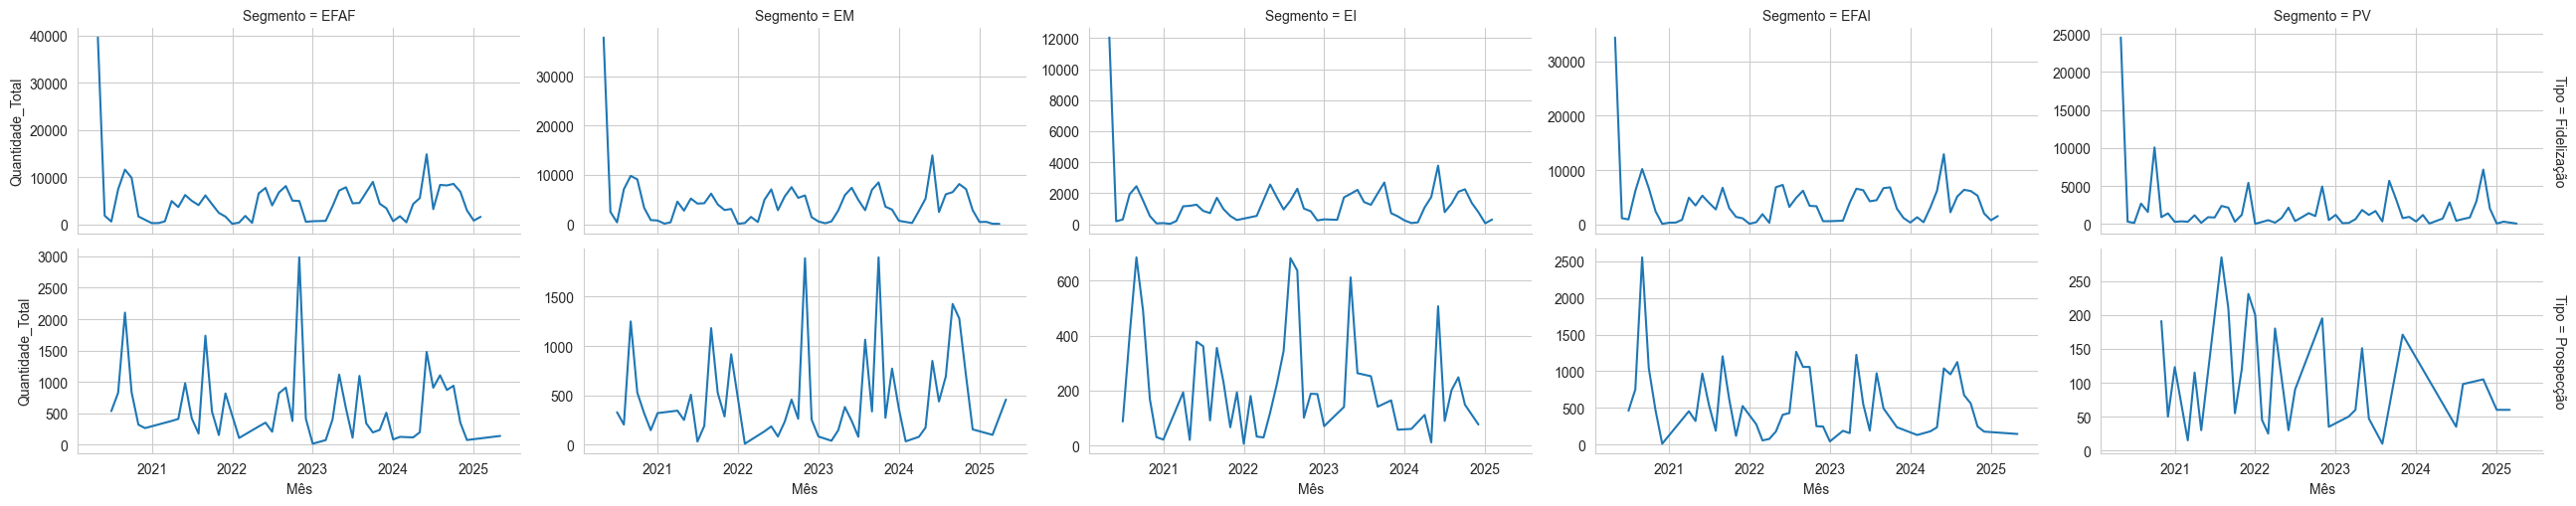

,mes_num,Quantidade_Total,Percentual_%
4,5,231000,22.242186
8,9,155358,14.958881
9,10,136015,13.096411
5,6,133799,12.883040
7,8,107094,10.311708
10,11,87698,8.444135
6,7,61493,5.920947
3,4,45669,4.397309
11,12,43207,4.160252
2,3,13286,1.279263


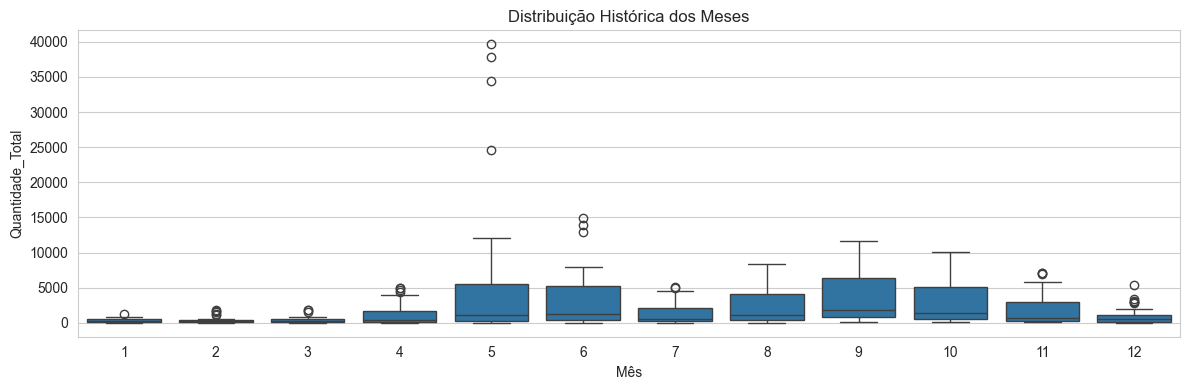

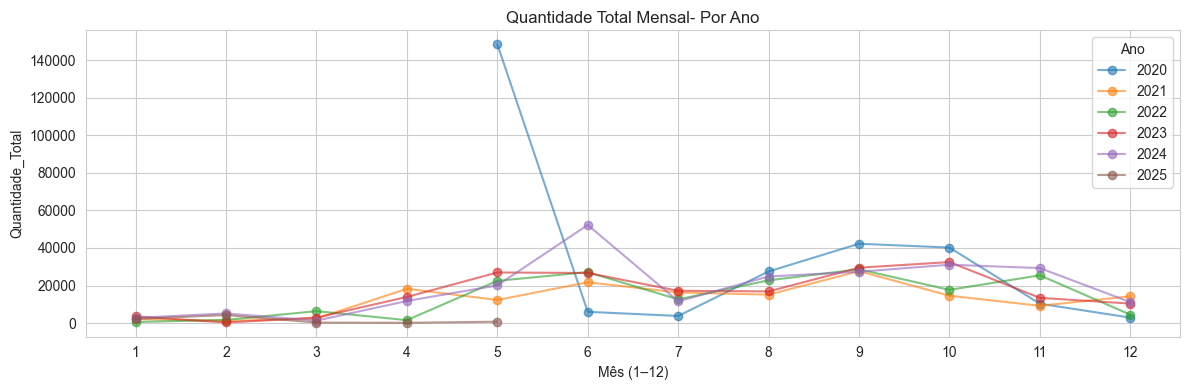

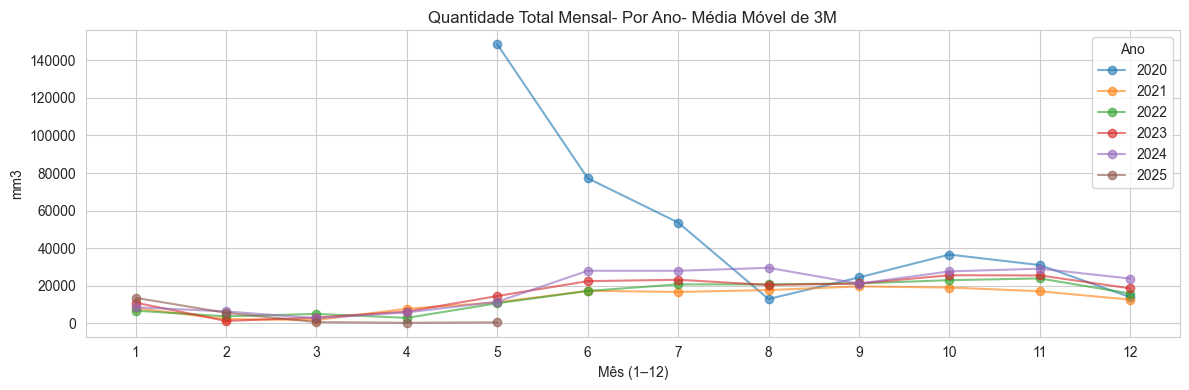

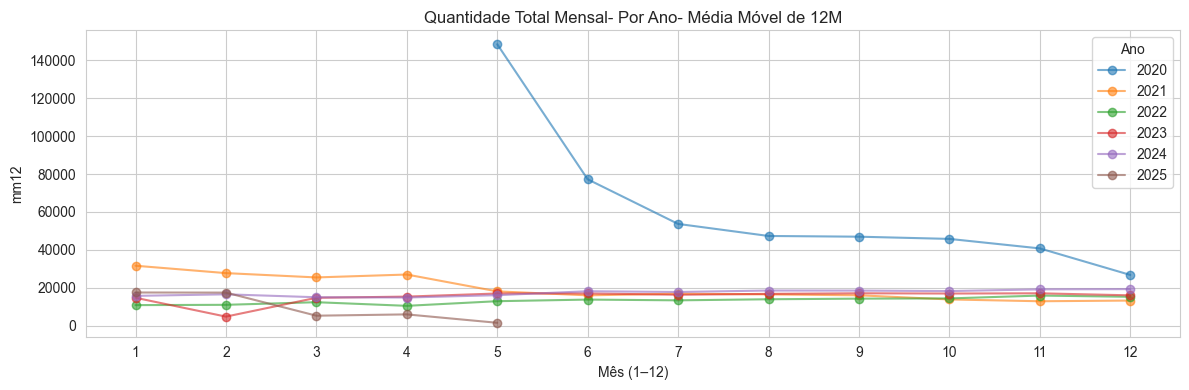

In [14]:
group_columns=['Segmento', 'Tipo','Mes']

df_group_input=df_raw_input.groupby(group_columns)['Quantidade_Total'].sum().reset_index()
df_group_input.sort_values(by='Mes', inplace=True)
df_group_input.reset_index(inplace=True, drop=True)
df_group_input['ano'] = df_group_input['Mes'].dt.year
df_group_input['mes_num'] = df_group_input['Mes'].dt.month
df_group_input['trimestre']=df_raw_input['Mes'].dt.to_period('Q').dt.to_timestamp()
df_group_input['mm3'] = (
    df_group_input.groupby(['Segmento','Tipo'])['Quantidade_Total']
    .transform(lambda s: s.rolling(3, min_periods=1).mean())
)

df_group_input['mm12'] = (
    df_group_input.groupby(['Segmento','Tipo'])['Quantidade_Total']
    .transform(lambda s: s.rolling(12, min_periods=1).mean())
)
display(df_group_input)

#split dos agrupamentos
g = sns.FacetGrid(df_group_input, col='Segmento', row='Tipo', height=2.6, aspect=2, margin_titles=True, sharey=False)
g.map_dataframe(sns.lineplot, x='Mes', y='Quantidade_Total', estimator='sum', ci=None)
g.set_axis_labels('Mês','Quantidade_Total')    
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'split_agrupamentos.png'))
plt.show()


#box dos meses
df_mes = df_group_input.groupby('mes_num', as_index=False)['Quantidade_Total'].sum()
total = df_mes['Quantidade_Total'].sum()
df_mes.sort_values(by='Quantidade_Total', inplace=True, ascending=False)
df_mes['Percentual_%'] = 100 * df_mes['Quantidade_Total'] / total
display(df_mes)
plt.figure(figsize=(12,4))
sns.boxplot(data=df_group_input, x='mes_num', y='Quantidade_Total')
plt.title('Distribuição Histórica dos Meses')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'box_quantiade_mes.png'))
plt.show()


#detalhamento do ano
plt.figure(figsize=(12,4))
for ano, sub in df_group_input.groupby('ano'):
    s = (sub.groupby('mes_num')['Quantidade_Total'].sum()
         .reindex(range(1,13), fill_value=np.nan))
    plt.plot(range(1,13), s.values, marker='o', alpha=0.6, label=str(ano))
plt.title('Quantidade Total Mensal- Por Ano')
plt.xticks(range(1,13)); plt.xlabel('Mês (1–12)'); plt.ylabel('Quantidade_Total')
plt.legend(title='Ano')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_ano.png'))
plt.show()

plt.figure(figsize=(12,4))
for ano, sub in df_group_input.groupby('ano'):
    s = (sub.groupby('mes_num')['mm3'].sum()
         .reindex(range(1,13), fill_value=np.nan))
    plt.plot(range(1,13), s.values, marker='o', alpha=0.6, label=str(ano))
plt.title('Quantidade Total Mensal- Por Ano- Média Móvel de 3M')
plt.xticks(range(1,13)); plt.xlabel('Mês (1–12)'); plt.ylabel('mm3')
plt.legend(title='Ano')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_ano_mm3.png'))
plt.show()

plt.figure(figsize=(12,4))
for ano, sub in df_group_input.groupby('ano'):
    s = (sub.groupby('mes_num')['mm12'].sum()
         .reindex(range(1,13), fill_value=np.nan))
    plt.plot(range(1,13), s.values, marker='o', alpha=0.6, label=str(ano))
plt.title('Quantidade Total Mensal- Por Ano- Média Móvel de 12M')
plt.xticks(range(1,13)); plt.xlabel('Mês (1–12)'); plt.ylabel('mm12')
plt.legend(title='Ano')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_ano_mm12.png'))
plt.show()



## 4.Agrupamento por Tipo

Especificamente sobre a tipo do material nao parece ser um ganho utilizar como criterio de agrupamento, como é o mesmo material com o fins distintos parece razoável ignorar esse agrupamento

3m tem um up relevante, que vemos uma quebra em alguns mensais, mas claramente existe um grupo de meses onde a demanda é significativamente maior
12m tem um padrao bem claro de reversão a média

Tipo,Mes,Fidelização,Prospecção
Tipo,,,
Mes,1.000000,-0.169787,-0.106382
Fidelização,-0.169787,1.000000,0.677699
Prospecção,-0.106382,0.677699,1.000000


,Tipo,Quantidade_Total,Percentual_%
0,Fidelização,949816,91.454475
1,Prospecção,88751,8.545525


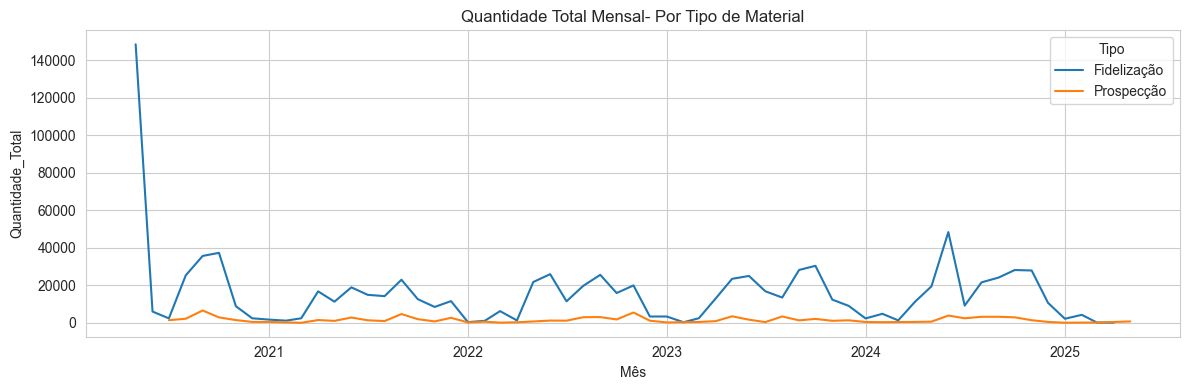

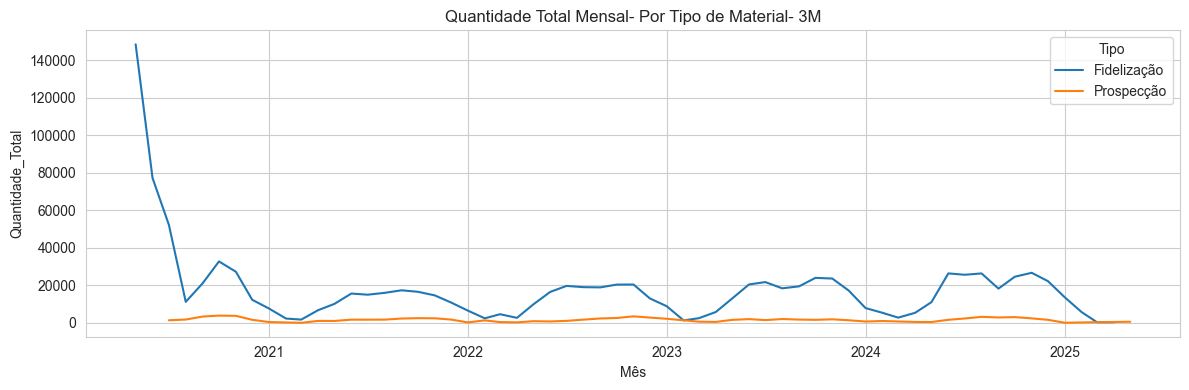

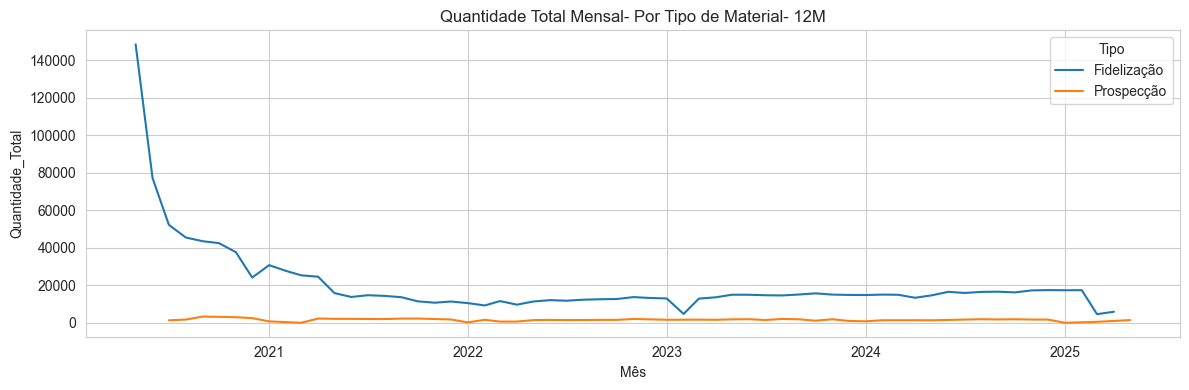

In [15]:
#agrupamento por tipo
df_tipo = df_group_input.groupby('Tipo', as_index=False)['Quantidade_Total'].sum()
total = df_tipo['Quantidade_Total'].sum()
df_tipo.sort_values(by='Quantidade_Total', inplace=True, ascending=False)
df_tipo['Percentual_%'] = 100 * df_tipo['Quantidade_Total'] / total
display(pd.pivot_table(df_group_input.groupby(['Tipo','Mes'], as_index=False)['Quantidade_Total'].sum(), values='Quantidade_Total', index=['Mes'], columns='Tipo').reset_index().corr())
display(df_tipo)
plt.figure(figsize=(12,4))
sns.lineplot(data=df_group_input, x='Mes', y='Quantidade_Total', hue='Tipo', estimator='sum', ci=None)
plt.title('Quantidade Total Mensal- Por Tipo de Material')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.legend(title='Tipo')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_tipo.png'))
plt.show()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_group_input, x='Mes', y='mm3', hue='Tipo', estimator='sum', ci=None)
plt.title('Quantidade Total Mensal- Por Tipo de Material- 3M')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.legend(title='Tipo')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_tipo_mm3.png'))
plt.show()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_group_input, x='Mes', y='mm12', hue='Tipo', estimator='sum', ci=None)
plt.title('Quantidade Total Mensal- Por Tipo de Material- 12M')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.legend(title='Tipo')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_tipo_mm12.png'))
plt.show()

## 5.Agrupamento por Segmento

Segmentos são relativamente bem distribuídos e equilibrado com apenas um grupo de EI/PV sendo pequeno.

o padrao é analogo ao tipos:
3m tem um up relevante, que vemos uma quebra em alguns mensais, mas claramente existe um grupo de meses onde a demanda é significativamente maior
12m tem um padrao bem claro de reversão a média
segmentos parecem evoluir juntos, entao acredito que vale fazer os testes com uma serie agrupada e dps explitar durante os fits do modelo


,Segmento,Quantidade_Total,Percentual_%
0,EFAF,309627,29.812906
3,EM,280839,27.041009
1,EFAI,257267,24.771344
4,PV,110216,10.612315
2,EI,80618,7.762426


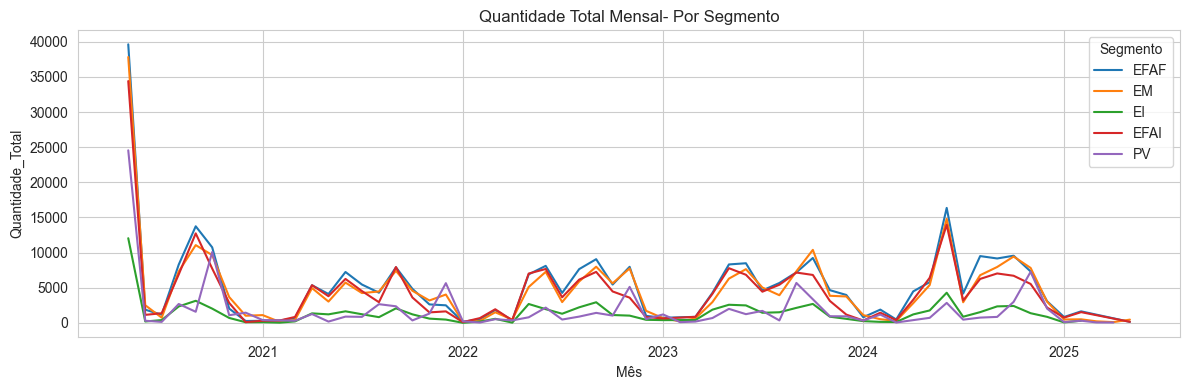

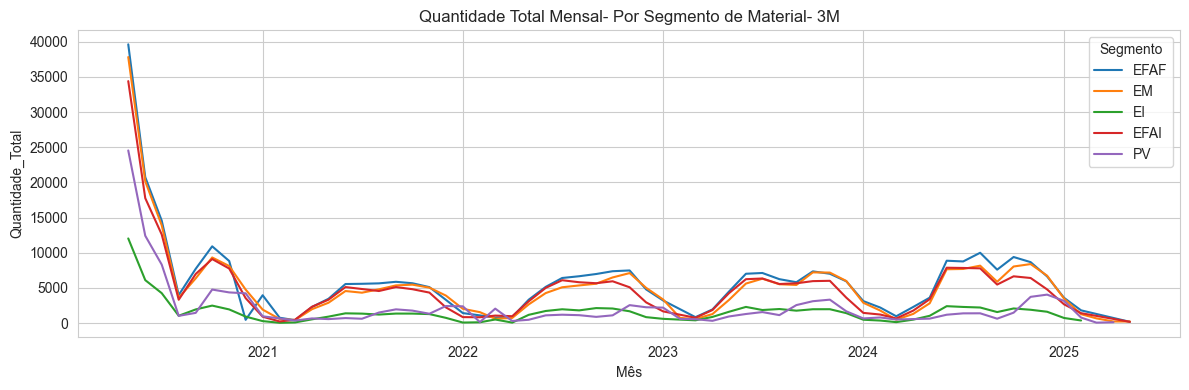

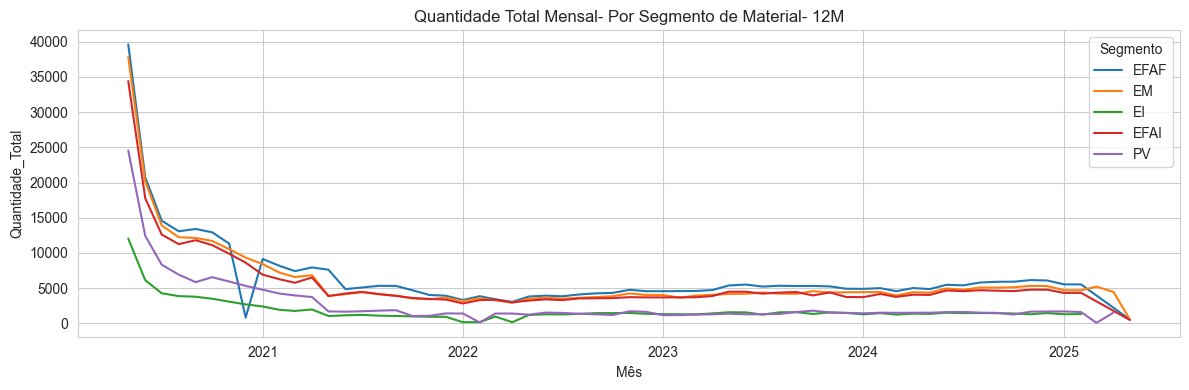

In [16]:
#agrupamento por segmento
df_segmento = df_group_input.groupby('Segmento', as_index=False)['Quantidade_Total'].sum()
total = df_segmento['Quantidade_Total'].sum()
df_segmento.sort_values(by='Quantidade_Total', inplace=True, ascending=False)
df_segmento['Percentual_%'] = 100 * df_segmento['Quantidade_Total'] / total

display(df_segmento)
plt.figure(figsize=(12,4))
sns.lineplot(data=df_group_input, x='Mes', y='Quantidade_Total', hue='Segmento', estimator='sum', ci=None)
plt.title('Quantidade Total Mensal- Por Segmento')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.legend(title='Segmento')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_segmento.png'))
plt.show()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_group_input, x='Mes', y='mm3', hue='Segmento', estimator='sum', ci=None)
plt.title('Quantidade Total Mensal- Por Segmento de Material- 3M')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.legend(title='Segmento')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_segmento_mm3.png'))
plt.show()

plt.figure(figsize=(12,4))
sns.lineplot(data=df_group_input, x='Mes', y='mm12', hue='Segmento', estimator='sum', ci=None)
plt.title('Quantidade Total Mensal- Por Segmento de Material- 12M')
plt.xlabel('Mês'); plt.ylabel('Quantidade_Total')
plt.legend(title='Segmento')
plt.tight_layout()
plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),'quantidade_segmento_mm12.png'))
plt.show()

## 6.Análise Estatística de Séries Temporais (dado total e sem agrupamento)

nenhuma das variaveis demonstrou alguma capacidade preditiva em particular, os padrões de meses parecem se sobresair, esse resultado é esperado, uma vez que a demanda deve ser dependente apenas das época do mercado e nao do segmento/tipo especifico, ainda que alguns segmentos e tipos tenham maior demanda, essa maior demanda nao necessáriamente é relevante para o tipo.

vamos fazer a analise das estatísticas relevantes como estacionariedade usando os grupos totais, sem a segmentação e generalizar as conclusões para os demais, em momento oportuno podemos particularizar

descritivas:
distribuicao vai ter leve assimetria para a direita por conta dos niveis de média e mediana, dispersão é bem alta
assimetria é moderada e positiva -> deve valer transformar em log
curtose mostra uma leptocurtica leve
autocorrelaçao é moderada em 1, minima em 3 e muito alta em 12

resumo
ADF e KPSS: testes de estacionariedade da série, a diferença é que o KPSS ve se ela é estacionaria para uma tendencia, coisa que deve ser provável já que a serie tem tendencia

anova: verifica medias iguais para cada mes, se as medias divergem deve ter padrao sazonal

kruskal-wallis: ve se a distribuição de cada mes é igual, mais forte do que o anova e também tenta medir padrao de sazonalidade


graficos:
na decomposicao vemos tendencia, na 3m o padrao oscilatorio fica curto e instável, há algum ciclo de 3m, mas nao consistente.
residuos tem dispersão moderada
o de 12m é mais forte do que o de 3m sem dúvida, mas tem uma baixa amostragem no geral

ACF 3M:
Autocorrelacao positive ate lag2
PCAF picoem lag 1
reduzem a evidencia de um ciclo estritamente trimestral

ACF/PACF 12M:
picos visiveis em lag12, confirma uma sazo mais robusta

conclusão:
a série é estacionária entorno da tendencia, temos sazonalidade confirmada



C:\Users\Lucas\AppData\Local\Temp\ipykernel_14792\1247541381.py:51: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(y, regression='c', nlags='auto')


,Métrica,Valor
0,count,48.000000
1,mean,15614.020833
2,std,11289.615666
3,min,316.000000
4,25%,4992.000000
5,50%,14412.000000
6,75%,24961.750000
7,max,52233.000000
8,Assimetria (skew),0.634839
9,Curtose (excesso),0.467154


,Teste,Estatística,p-valor,H0,Indício
0,ADF-tendencia,-6.966697,1.680479e-08,Rejeita,Estacionária
1,ADF-sem-tendencia,-1.300128,6.291139e-01,Não Rejeita,Não estacionária
2,KPSS-sem-tendencia,0.272690,1.000000e-01,Não Rejeita,Estacionária
3,ANOVA (mês),9.573889,9.450021e-08,Rejeita,médias por mês diferem (sazonalidade)
4,Kruskal–Wallis (mês),36.846939,1.222373e-04,Rejeita,distribuições por mês diferem (sazonalidade)


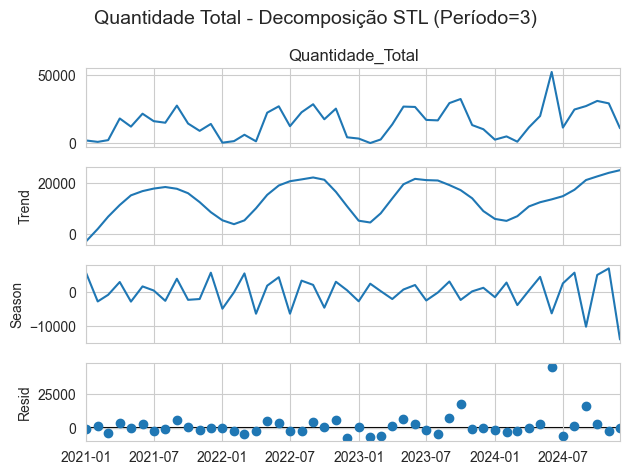

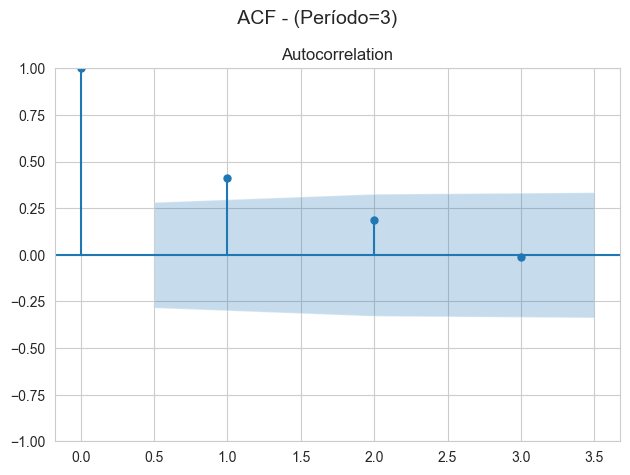

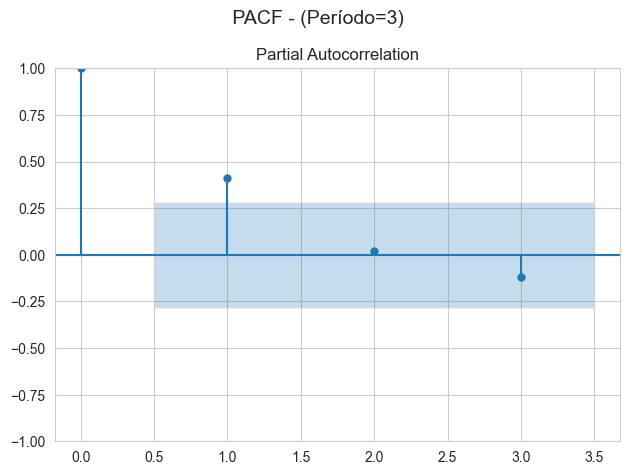

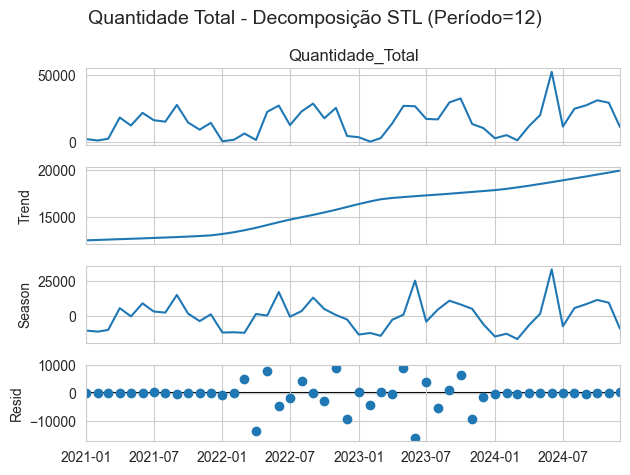

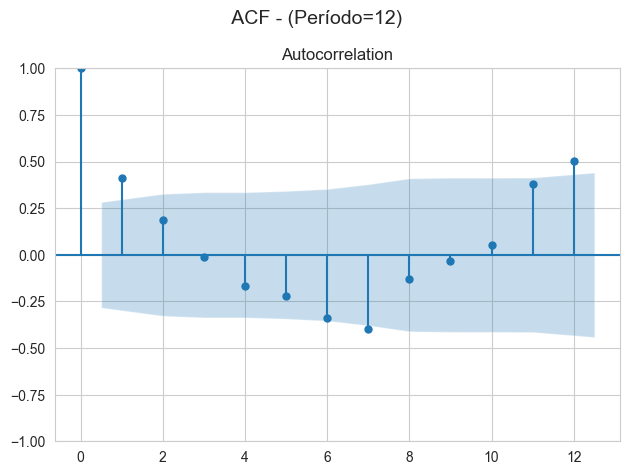

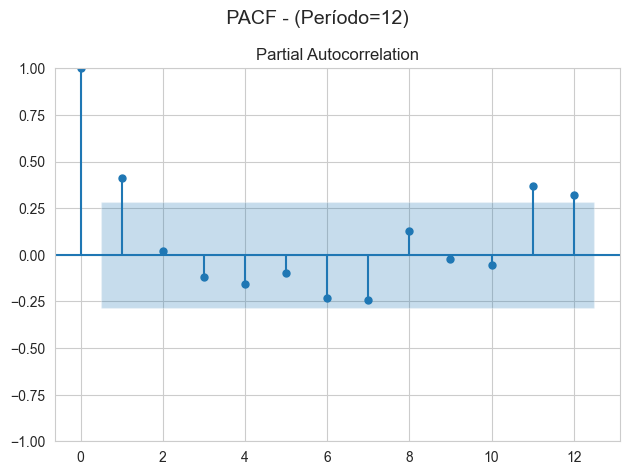

In [17]:
from scipy.stats import skew, kurtosis, f_oneway, kruskal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#remove os pontos de 2020 e 2025 por nao estarem completos -> impacta significativamente o resultado
df_stats=df_total.copy(deep=True)
df_stats['ano']=df_total.Mes.dt.year
df_stats['mes_num'] = df_stats['Mes'].dt.month
df_stats.query('2020<ano<2025',inplace=True)
df_descritive_stats=df_stats['Quantidade_Total'].describe().reset_index()
y = df_stats.set_index('Mes')['Quantidade_Total']

df_descritivo = y.describe().to_frame(name='Valor').reset_index().rename(columns={'index':'Métrica'})
df_descritivo = pd.concat([
    df_descritivo,
    pd.DataFrame([{'Métrica':'Assimetria (skew)', 'Valor': skew(y)}]),
    pd.DataFrame([{'Métrica':'Curtose (excesso)', 'Valor': kurtosis(y)}]),
    pd.DataFrame([{'Métrica':'Autocorr lag1', 'Valor': y.autocorr(lag=1)}]),
    pd.DataFrame([{'Métrica':'Autocorr lag3', 'Valor': y.autocorr(lag=3)}]),
    pd.DataFrame([{'Métrica':'Autocorr lag6', 'Valor': y.autocorr(lag=3)}]),
    pd.DataFrame([{'Métrica':'Autocorr lag9', 'Valor': y.autocorr(lag=9)}]),
    pd.DataFrame([{'Métrica':'Autocorr lag12', 'Valor': y.autocorr(lag=12)}]),
    pd.DataFrame([{'Métrica':'Autocorr lag24', 'Valor': y.autocorr(lag=24)}]), #alta, mas deve perder explicabilidade, amostragem bem baixa
    pd.DataFrame([{'Métrica':'Total (soma)', 'Valor': y.sum()}]),
], ignore_index=True)

linhas = []

def add_row(teste, estat=None, pval=None, conclusao=None):
    linhas.append({
        'Teste': teste,
        'Estatística': estat,
        'p-valor': pval,
        'H0': 'Rejeita' if pval<0.05 else 'Não Rejeita',
        'Indício': conclusao
    })

#ADF
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(y,regression='ct', autolag='AIC')
concl_adf = 'Estacionária' if adf_p < 0.05 else 'Não estacionária'
add_row('ADF-tendencia', adf_stat, adf_p, concl_adf)

adf_stat, adf_p, _, _, adf_crit, _ = adfuller(y,regression='c', autolag='AIC')
concl_adf = 'Estacionária' if adf_p < 0.05 else 'Não estacionária'
add_row('ADF-sem-tendencia', adf_stat, adf_p, concl_adf)

#kpss
kpss_stat, kpss_p, _, kpss_crit = kpss(y, regression='c', nlags='auto')
concl_kpss = 'Estacionária' if kpss_p > 0.05 else 'Não estacionária'
add_row('KPSS-sem-tendencia', kpss_stat, kpss_p, concl_kpss)

# ANOVA
grupos = [df_stats.loc[df_stats['mes_num']==m, 'Quantidade_Total'].values for m in range(1,13)]

anova_F, anova_p = f_oneway(*grupos)
concl_anova = 'médias por mês diferem (sazonalidade)' if anova_p < 0.05 else 'sem evidência de diferença entre meses'
add_row('ANOVA (mês)', anova_F, anova_p, concl_anova)

# Kruskal–Wallis
kruskal_H, kruskal_p = kruskal(*grupos)
concl_kruskal = 'distribuições por mês diferem (sazonalidade)' if kruskal_p < 0.05 else 'sem evidência de diferença entre meses'
add_row('Kruskal–Wallis (mês)', kruskal_H, kruskal_p, concl_kruskal)


df_summary_tests = pd.DataFrame(linhas, columns=['Teste','Estatística','p-valor','H0','Indício'])


display(df_descritivo)
display(df_summary_tests)

for period in [3,12]: 
    if period>1:
        stl = STL(y, period=period, robust=True).fit()
        fig = stl.plot()
        fig.suptitle(f'Quantidade Total - Decomposição STL (Período={period})', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),f'decomposicao_stl_{period}.png'))
        plt.show()

    fig=plot_acf(y, lags=period)
    fig.suptitle(f' ACF - (Período={period})', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),f'decomposicao_acf_{period}.png'))
    plt.show()
    plt.show()

    fig=plot_pacf(y, lags=period, method='ywm')
    fig.suptitle(f' PACF - (Período={period})', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(PARAMS_PATHS.get('output_path'),f'decomposicao_pacf_{period}.png'))
    plt.show()
    plt.show()


In [31]:
group_columns=['Segmento', 'Mes']

df_group_input=df_raw_input.groupby(group_columns)['Quantidade_Total'].sum().reset_index()
df_group_input.sort_values(by='Mes', inplace=True)
df_group_input.reset_index(inplace=True, drop=True)
df_group_input['ano'] = df_group_input['Mes'].dt.year
df_group_input['mes_num'] = df_group_input['Mes'].dt.month
df_group_input['trimestre']=df_raw_input['Mes'].dt.to_period('Q').dt.to_timestamp()


df_pivot=pd.pivot_table(data=df_group_input, index='Mes',
               columns='Segmento',values='Quantidade_Total').sort_index()

df_pivot.corr()

Segmento,EFAF,EFAI,EI,EM,PV
Segmento,,,,,
EFAF,1.000000,0.986474,0.975314,0.988031,0.817567
EFAI,0.986474,1.000000,0.984385,0.972489,0.794272
EI,0.975314,0.984385,1.000000,0.967500,0.801742
EM,0.988031,0.972489,0.967500,1.000000,0.860562
PV,0.817567,0.794272,0.801742,0.860562,1.000000


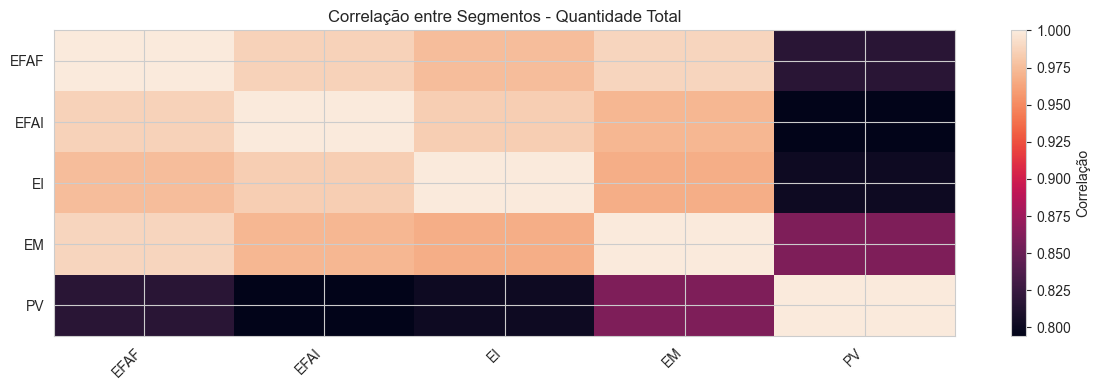

In [32]:
# Matriz de correlação entre segmentos
corr_matrix = df_pivot.corr()

plt.figure(figsize=(12,4))
im = plt.imshow(corr_matrix, aspect='auto')

plt.title('Correlação entre Segmentos - Quantidade Total')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)

plt.colorbar(im, label='Correlação')

plt.tight_layout()
plt.savefig(
    os.path.join(
        PARAMS_PATHS.get('output_path'),
        'correlacao_segmentos_quantidade_total.png'
    )
)
plt.show()
